# Import Libraries and Drive

In [ ]:
pip install xgboost

In [ ]:
pip install prophet

In [ ]:
pip install statsmodels

In [ ]:
import pickle
import os

from datetime import datetime
import pandas as pd
from pandas.tseries.offsets import Week
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import random

import seaborn as sns
sns.set_style('whitegrid')


from sklearn.metrics import mean_squared_error

import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from prophet import Prophet

pd.set_option('display.max_columns', None)  # or 1000

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Data/df_DSMARKET')
df.head(5)

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Subsidy_week_flag,Event_week_flag
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-29,2011,1,1,201104,Saturday,6,29,1,0,10.968041,0.0,No_event,4.0,0,False,False
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,2011,1,1,201104,Sunday,7,30,2,0,10.968041,0.0,No_event,4.0,0,False,False
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-31,2011,1,1,201105,Monday,1,31,3,0,10.968041,0.0,No_event,4.0,0,False,True
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,2011,1,2,201105,Tuesday,2,1,4,0,10.968041,0.0,No_event,4.0,0,False,True
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-02,2011,1,2,201105,Wednesday,3,2,5,0,10.968041,0.0,No_event,4.0,0,False,True


# EDA

In [ ]:
df2 = df.copy()

In [ ]:
df2.columns

Index(['id', 'item', 'category', 'department', 'store', 'store_code', 'region',
       'date', 'year', 'quarter', 'month', 'yearweek', 'weekday',
       'weekday_int', 'day', 'd', 'units_sold', 'price_per_unit', 'revenue',
       'event', 'product_cluster', 'store_cluster', 'Subsidy_week_flag',
       'Event_week_flag'],
      dtype='object')

## Subsidy_week removal

In [ ]:
# df2[((df2['day'] == 3) & (df2['weekday_int'] >= 5) & (df2['weekday_int'] <= 7))]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Subsidy_week_flag,Event_week_flag
64,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-04-03,2011,2,4,201113,Sunday,7,3,65,0,10.968041,0.0,No_event,4.0,0,True,False
125,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-06-03,2011,2,6,201122,Friday,5,3,126,0,10.968041,0.0,No_event,4.0,0,True,False
155,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-07-03,2011,3,7,201126,Sunday,7,3,156,0,10.968041,0.0,No_event,4.0,0,True,False
217,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-09-03,2011,3,9,201135,Saturday,6,3,218,0,10.968041,0.0,No_event,4.0,0,True,False
308,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-12-03,2011,4,12,201148,Saturday,6,3,309,0,10.968041,0.0,No_event,4.0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327012,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2015-05-03,2015,2,5,201517,Sunday,7,3,1556,10,1.200000,12.0,No_event,3.0,0,True,False
58327073,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2015-07-03,2015,3,7,201526,Friday,5,3,1617,0,1.200000,0.0,No_event,3.0,0,True,True
58327165,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2015-10-03,2015,4,10,201539,Saturday,6,3,1709,2,1.200000,2.4,No_event,3.0,0,True,False
58327257,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-01-03,2016,1,1,201552,Sunday,7,3,1801,0,1.200000,0.0,No_event,3.0,0,True,True


In [ ]:
# df2[df2['yearweek']==201526]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Subsidy_week_flag,Event_week_flag
1612,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2015-06-29,2015,2,6,201526,Monday,1,29,1613,0,10.9858,0.0000,No_event,4.0,0,False,True
1613,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2015-06-30,2015,2,6,201526,Tuesday,2,30,1614,0,10.9858,0.0000,No_event,4.0,0,False,True
1614,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2015-07-01,2015,3,7,201526,Wednesday,3,1,1615,1,10.9858,10.9858,No_event,4.0,0,False,True
1615,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2015-07-02,2015,3,7,201526,Thursday,4,2,1616,1,10.9858,10.9858,No_event,4.0,0,False,True
1616,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2015-07-03,2015,3,7,201526,Friday,5,3,1617,1,10.9858,10.9858,No_event,4.0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327071,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2015-07-01,2015,3,7,201526,Wednesday,3,1,1615,0,1.2000,0.0000,No_event,3.0,0,False,True
58327072,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2015-07-02,2015,3,7,201526,Thursday,4,2,1616,0,1.2000,0.0000,No_event,3.0,0,False,True
58327073,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2015-07-03,2015,3,7,201526,Friday,5,3,1617,0,1.2000,0.0000,No_event,3.0,0,True,True
58327074,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2015-07-04,2015,3,7,201526,Saturday,6,4,1618,0,1.2000,0.0000,4th_of_July,3.0,0,True,True


In [ ]:
weekend_count = df2[((df2['day'] == 3) & (df2['weekday_int'] >= 5) & (df2['weekday_int'] <= 7))].shape[0]
not_weekend_count = df2[((df2['day'] == 3) & (df2['weekday_int'] < 5))].shape[0]
print(f"Number of times the 3rd of the month is a weekend: {weekend_count}")
print(f"Number of times the 3rd of the month is not a weekend: {not_weekend_count}")

Number of times the 3rd of the month is a weekend: 792740
Number of times the 3rd of the month is not a weekend: 1128130


In [ ]:
total_count = weekend_count + not_weekend_count
weekend_percentage = (weekend_count / total_count) * 100
not_weekend_percentage = (not_weekend_count / total_count) * 100

print(f"Percentage of times the 3rd of the month is a weekend: {weekend_percentage:.2f}%")
print(f"Percentage of times the 3rd of the month is not a weekend: {not_weekend_percentage:.2f}%")

Percentage of times the 3rd of the month is a weekend: 41.27%
Percentage of times the 3rd of the month is not a weekend: 58.73%


El subsidy week son SIEMPRE 2 semanas

In [ ]:
df2.groupby('weekday')['weekday_int'].value_counts()

,,count
weekday,weekday_int,
Friday,5,8323770
Monday,1,8323770
Saturday,6,8354260
Sunday,7,8354260
Thursday,4,8323770
Tuesday,2,8323770
Wednesday,3,8323770


In [ ]:
# # Identify consecutive sequences of Subsidy_week_flag being True
# df2['subsidy_group'] = (df2['Subsidy_week_flag'] != df2['Subsidy_week_flag'].shift(1)).cumsum()

# # Filter only the sequences where Subsidy_week_flag is True
# subsidy_sequences = df2[df2['Subsidy_week_flag'] == True]

# # Count the length of each sequence within each id and subsidy_group
# sequence_lengths = subsidy_sequences.groupby(['id', 'subsidy_group'])['yearweek'].nunique()

# # Count how many sequences are 2 weeks long and how many are 1 week long
# two_week_sequences = (sequence_lengths == 2).sum()
# one_week_sequences = (sequence_lengths == 1).sum()

# print(f"Number of times Subsidy_week_flag is True for 2 consecutive weeks: {two_week_sequences}")
# print(f"Number of times Subsidy_week_flag is True for only 1 week: {one_week_sequences}")

Number of times Subsidy_week_flag is True for 2 consecutive weeks: 1920870
Number of times Subsidy_week_flag is True for only 1 week: 0


In [ ]:
subsidy_day1 = df2[((df2['day'] == 3) & (df2['weekday_int'] == 1))].shape[0]
print(f"Number of times the 3rd of the month is a Monday: {subsidy_day1}")

Number of times the 3rd of the month is a Monday: 243920


In [ ]:
df2.drop('subsidy_group', axis=1, inplace=True)

In [ ]:
df2

In [ ]:
# Calculate the average sales per day for each store
avg_sales_per_day = df2.groupby(['store', 'day'])['units_sold'].mean().reset_index()

# Find the day with the highest average sales for each store
max_avg_sales_per_day = avg_sales_per_day.loc[avg_sales_per_day.groupby('store')['units_sold'].idxmax()]

# Find the day with the lowest average sales for each store
min_avg_sales_per_day = avg_sales_per_day.loc[avg_sales_per_day.groupby('store')['units_sold'].idxmin()]


# Calculate the overall average sales per store (excluding the max/min days)
overall_avg_sales_per_store = avg_sales_per_day.groupby('store')['units_sold'].mean().reset_index()
overall_avg_sales_per_store = overall_avg_sales_per_store.rename(columns={'units_sold': 'overall_avg_units_sold'})

# Merge with the max and min results to compare
max_avg_sales_per_day = max_avg_sales_per_day.merge(overall_avg_sales_per_store, on='store')
min_avg_sales_per_day = min_avg_sales_per_day.merge(overall_avg_sales_per_store, on='store')

# Calculate the difference
max_avg_sales_per_day['difference'] = max_avg_sales_per_day['units_sold'] - max_avg_sales_per_day['overall_avg_units_sold']
min_avg_sales_per_day['difference'] = min_avg_sales_per_day['units_sold'] - min_avg_sales_per_day['overall_avg_units_sold']

# Format the results for the maximum sales day
for index, row in max_avg_sales_per_day.iterrows():
    print(f"The day of the month {row['day']} is the one with the most units_sold in average, in the store {row['store']}, by {row['difference']:.2f} more than the rest of the days.")

# Format the results for the minimum sales day
for index, row in min_avg_sales_per_day.iterrows():
    print(f"The day of the month {row['day']} is the one with the least units_sold in average, in the store {row['store']}, by {abs(row['difference']):.2f} less than the rest of the days.")

The day of the month 3 is the one with the most units_sold in average, in the store Back_Bay, by 0.13 more than the rest of the days.
The day of the month 3 is the one with the most units_sold in average, in the store Brooklyn, by 0.05 more than the rest of the days.
The day of the month 3 is the one with the most units_sold in average, in the store Greenwich_Village, by 0.15 more than the rest of the days.
The day of the month 1 is the one with the most units_sold in average, in the store Harlem, by 0.04 more than the rest of the days.
The day of the month 3 is the one with the most units_sold in average, in the store Midtown_Village, by 0.08 more than the rest of the days.
The day of the month 3 is the one with the most units_sold in average, in the store Queen_Village, by 0.29 more than the rest of the days.
The day of the month 13 is the one with the most units_sold in average, in the store Roxbury, by 0.13 more than the rest of the days.
The day of the month 15 is the one with the

In [ ]:
# Initialize lists to store the results
stores = []
best_days = []
worst_days = []
pct_differences = []

# Collect data for the best day (most units sold)
for index, row in max_avg_sales_per_day.iterrows():
    stores.append(row['store'])
    best_days.append(row['day'])

# Collect data for the worst day (least units sold)
for index, row in min_avg_sales_per_day.iterrows():
    worst_days.append(row['day'])
    pct_differences.append(abs(row['difference']))  # Store the absolute difference for clarity

In [ ]:
# Create the DataFrame
results_df = pd.DataFrame({
    'Store': stores,
    'Best Day': best_days,
    'Worst Day': worst_days,
    'Pct Difference': pct_differences
})

results_df

,Store,Best Day,Worst Day,Pct Difference
0,Back_Bay,3,25,0.140301
1,Brooklyn,3,25,0.066572
2,Greenwich_Village,3,25,0.157471
3,Harlem,1,25,0.093539
4,Midtown_Village,3,25,0.103701
5,Queen_Village,3,25,0.208398
6,Roxbury,13,25,0.143439
7,South_End,15,25,0.143682
8,Tribeca,3,25,0.232030
9,Yorktown,3,25,0.256538


In [ ]:
df2.groupby('year')['units_sold'].sum().sort_values(ascending=False)

,units_sold
year,
2015,13800811
2013,13135753
2014,13089776
2012,12061837
2011,8856585
2016,4750647


In [ ]:
df2.columns

Index(['id', 'item', 'category', 'department', 'store', 'store_code', 'region',
       'date', 'year', 'quarter', 'month', 'yearweek', 'weekday',
       'weekday_int', 'day', 'd', 'units_sold', 'price_per_unit', 'revenue',
       'event', 'product_cluster', 'store_cluster', 'Subsidy_week_flag',
       'Event_week_flag'],
      dtype='object')

In [ ]:
df2.drop(columns=['Subsidy_week_flag'], axis=1, inplace=True)

In [ ]:
df2.columns

Index(['id', 'item', 'category', 'department', 'store', 'store_code', 'region',
       'date', 'year', 'quarter', 'month', 'yearweek', 'weekday',
       'weekday_int', 'day', 'd', 'units_sold', 'price_per_unit', 'revenue',
       'event', 'product_cluster', 'store_cluster', 'Event_week_flag'],
      dtype='object')

### Features to create to replace Subsidy_week

Yo crearia:
- Flag: best_week_of_the_month: True si esa semana fue la que tuvo mas unidades vendidas ese mes
- Promedio de unidades vendidas de ese articulo por semana (avg_units_sold_week_1_of_month, avg_units_sold_week_2_of_month, avg_units_sold_week_3_of_month, avg_units_sold_week_4_of_month) agrupado por TRIMESTRE

## Report_df

In [ ]:
def report_df(df, verbose=True):
    """
    Genera un informe simple para el DataFrame proporcionado.

    """
    # Identificamos dtypes
    object_cols = df.select_dtypes(include=['object']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    bool_cols = df.select_dtypes(include=['bool']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns

    # DataFrame shape
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

    # Detailed report by data type
    print(f"\n{'-'*80}\nColumns of type Object ({len(object_cols)}):\n{list(object_cols)}")
    print(f"\n{'-'*80}\nColumns of type Int ({len(int_cols)}):\n{list(int_cols)}")
    print(f"\n{'-'*80}\nColumns of type Float ({len(float_cols)}):\n{list(float_cols)}")
    print(f"\n{'-'*80}\nColumns of type Boolean ({len(bool_cols)}):\n{list(bool_cols)}")
    print(f"\n{'-'*80}\nColumns of type Datetime ({len(datetime_cols)}):\n{list(datetime_cols)}\n")

    print('-'*80)

        # Nulos
    total_nulls = df.isnull().sum().sum()
    print(f"Total missing values: {total_nulls}")

    # Duplicados
    total_duplicates = df.duplicated().sum()
    print(f"Total duplicate rows: {total_duplicates}\n")

    MIN_DATE = df["date"].min()
    MAX_DATE = df["date"].max()
    print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}\n")

    print(f'Number of unique items: {df["item"].nunique()}')
    print(f'Number of unique id: {df["id"].nunique()}')
    print(f'Number of unique stores: {df["store"].nunique()}')
    print(f'Number of unique departments: {df["department"].nunique()}')
    print(f'Number of unique categories: {df["category"].nunique()}')

In [ ]:
report_df(df2)

Shape: 58327370 rows, 23 columns

--------------------------------------------------------------------------------
Columns of type Object (9):
['id', 'item', 'category', 'department', 'store', 'store_code', 'region', 'weekday', 'event']

--------------------------------------------------------------------------------
Columns of type Int (7):
['year', 'month', 'yearweek', 'day', 'd', 'units_sold', 'store_cluster']

--------------------------------------------------------------------------------
Columns of type Float (3):
['price_per_unit', 'revenue', 'product_cluster']

--------------------------------------------------------------------------------
Columns of type Boolean (1):
['Event_week_flag']

--------------------------------------------------------------------------------
Columns of type Datetime (1):
['date']

--------------------------------------------------------------------------------
Total missing values: 38260
Total duplicate rows: 0

Min date is 2011-01-29 00:00:00
Max da

In [ ]:
df2.isnull().sum()

,0
id,0
item,0
category,0
department,0
store,0
store_code,0
region,0
date,0
year,0
quarter,0


In [ ]:
# Encuentra los productos con valores nulos en 'product_cluster'
null_products = df2[df2['product_cluster'].isnull()]['item'].unique()
null_products

array(['ACCESORIES_1_112', 'HOME_&_GARDEN_2_162'], dtype=object)

## ID elminados por null en cluster y por ventas 0 desde 2014

In [ ]:
# Filto del 2014 en adelante
df_after_2014 = df2[df2['year'] >= 2014]

# Calcular la suma de units_sold por cada ID
total_units_sold_after_2014 = df_after_2014.groupby('id')['units_sold'].sum()

# Identifica los items con units_sold == 0
ids_with_zero_sales_2014 = total_units_sold_after_2014[total_units_sold_after_2014 == 0].index.tolist()

# Resultados
print(f"Total number of items with 0 units sold: {len(ids_with_zero_sales_2014)}")
print("IDs:", ids_with_zero_sales_2014)

Total number of items with 0 units sold: 7
IDs: ['ACCESORIES_1_335_BOS_1', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_PHI_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_PHI_3', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_2_394_BOS_3']


In [ ]:
# Filto del 2015 en adelante
df_after_2015 = df2[df2['year'] >= 2015]

# Calcular la suma de units_sold por cada ID
total_units_sold_after_2015 = df_after_2015.groupby('id')['units_sold'].sum()

# Identifica los items con units_sold == 0
ids_with_zero_sales_215 = total_units_sold_after_2015[total_units_sold_after_2015 == 0].index.tolist()

# Resultados
print(f"Total number of items with 0 units sold: {len(ids_with_zero_sales_215)}")
print("IDs:", ids_with_zero_sales_215)

Total number of items with 0 units sold: 16
IDs: ['ACCESORIES_1_210_NYC_1', 'ACCESORIES_1_335_BOS_1', 'ACCESORIES_1_335_BOS_2', 'ACCESORIES_1_335_BOS_3', 'ACCESORIES_1_335_NYC_2', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_NYC_4', 'ACCESORIES_1_335_PHI_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_PHI_3', 'HOME_&_GARDEN_1_356_NYC_3', 'HOME_&_GARDEN_1_356_NYC_4', 'SUPERMARKET_2_053_PHI_1', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_2_394_BOS_3', 'SUPERMARKET_3_751_NYC_4']


In [ ]:
# Combine the two lists
combined_ids = ids_with_zero_sales_215 + ids_with_zero_sales_2014

# Remove duplicates
unique_ids_to_del = list(set(combined_ids))

print(f"Total number of unique items with 0 units sold: {len(unique_ids_to_del)}")
print("Unique IDs:", unique_ids_to_del)

Total number of unique items with 0 units sold: 16
Unique IDs: ['HOME_&_GARDEN_1_356_NYC_3', 'ACCESORIES_1_335_NYC_4', 'SUPERMARKET_2_394_BOS_3', 'SUPERMARKET_3_751_NYC_4', 'ACCESORIES_1_335_BOS_1', 'ACCESORIES_1_335_PHI_2', 'SUPERMARKET_2_053_PHI_1', 'ACCESORIES_1_335_BOS_3', 'ACCESORIES_1_335_BOS_2', 'ACCESORIES_1_335_PHI_1', 'HOME_&_GARDEN_1_356_NYC_4', 'SUPERMARKET_2_129_BOS_3', 'ACCESORIES_1_335_PHI_3', 'ACCESORIES_1_335_NYC_2', 'ACCESORIES_1_210_NYC_1', 'ACCESORIES_1_335_NYC_3']


In [ ]:
# Eliminate the rows corresponding to the products in null_products and ids_with_zero_sales
df2 = df2[~df2['item'].isin(null_products) & ~df2['id'].isin(unique_ids_to_del)]

In [ ]:
df2['product_cluster'] = df2['product_cluster'].astype(int)
df2['product_cluster'].value_counts()

,count
product_cluster,
3,18399234
2,13159527
4,11148964
1,9641520
5,5909257


In [ ]:
df2.isnull().sum()

,0
id,0
item,0
category,0
department,0
store,0
store_code,0
region,0
date,0
year,0
quarter,0


In [ ]:
def print_deleted_ids(df, df2):
    # Get the unique IDs from both DataFrames
    original_ids = set(df['id'].unique())
    modified_ids = set(df2['id'].unique())

    # Identify the deleted IDs
    deleted_ids = original_ids - modified_ids

    # Print the result
    if deleted_ids:
        print(f"Deleted ID (total: {len(deleted_ids)}): {', '.join(deleted_ids)}")
    else:
        print("No IDs were deleted.")

In [ ]:
print_deleted_ids(df, df2)

Deleted ID (total: 36): HOME_&_GARDEN_2_162_NYC_4, ACCESORIES_1_335_NYC_4, ACCESORIES_1_335_PHI_2, ACCESORIES_1_112_PHI_1, HOME_&_GARDEN_2_162_BOS_1, SUPERMARKET_2_129_BOS_3, ACCESORIES_1_112_NYC_3, ACCESORIES_1_112_PHI_3, ACCESORIES_1_210_NYC_1, HOME_&_GARDEN_1_356_NYC_3, HOME_&_GARDEN_2_162_NYC_3, ACCESORIES_1_335_BOS_2, ACCESORIES_1_112_BOS_1, HOME_&_GARDEN_2_162_BOS_2, ACCESORIES_1_112_BOS_2, ACCESORIES_1_335_PHI_3, ACCESORIES_1_112_NYC_4, HOME_&_GARDEN_1_356_NYC_4, ACCESORIES_1_112_NYC_1, ACCESORIES_1_112_PHI_2, HOME_&_GARDEN_2_162_PHI_2, HOME_&_GARDEN_2_162_PHI_3, HOME_&_GARDEN_2_162_BOS_3, ACCESORIES_1_335_NYC_2, ACCESORIES_1_335_NYC_3, SUPERMARKET_3_751_NYC_4, HOME_&_GARDEN_2_162_PHI_1, ACCESORIES_1_335_BOS_1, ACCESORIES_1_112_BOS_3, SUPERMARKET_2_053_PHI_1, ACCESORIES_1_112_NYC_2, ACCESORIES_1_335_BOS_3, HOME_&_GARDEN_2_162_NYC_2, ACCESORIES_1_335_PHI_1, SUPERMARKET_2_394_BOS_3, HOME_&_GARDEN_2_162_NYC_1


## Outliers

In [ ]:
df2

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-29,2011,1,1,201104,Saturday,6,29,1,0,10.968041,0.0,No_event,4,0,False
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,2011,1,1,201104,Sunday,7,30,2,0,10.968041,0.0,No_event,4,0,False
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-31,2011,1,1,201105,Monday,1,31,3,0,10.968041,0.0,No_event,4,0,True
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,2011,1,2,201105,Tuesday,2,1,4,0,10.968041,0.0,No_event,4,0,True
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-02,2011,1,2,201105,Wednesday,3,2,5,0,10.968041,0.0,No_event,4,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-20,2016,2,4,201616,Wednesday,3,20,1909,0,1.200000,0.0,No_event,3,0,False
58327366,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-21,2016,2,4,201616,Thursday,4,21,1910,0,1.200000,0.0,No_event,3,0,False
58327367,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-22,2016,2,4,201616,Friday,5,22,1911,0,1.200000,0.0,No_event,3,0,False
58327368,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-23,2016,2,4,201616,Saturday,6,23,1912,0,1.200000,0.0,No_event,3,0,False


### units_sold

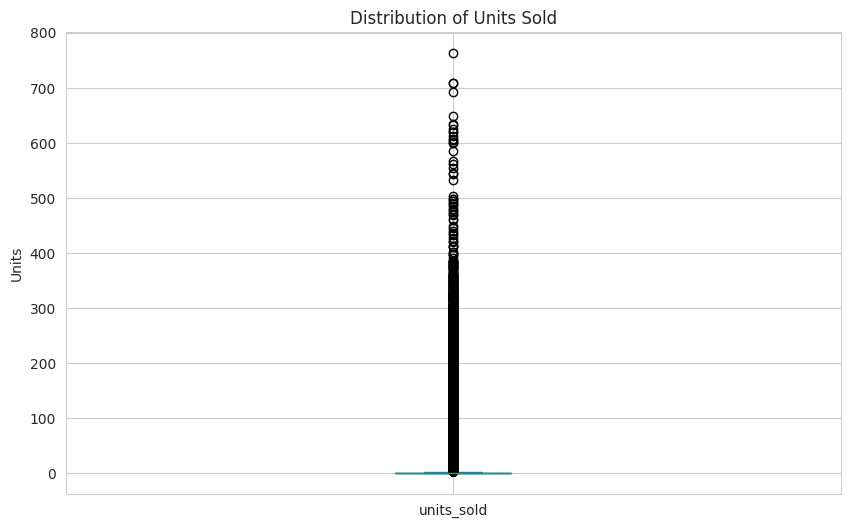

In [ ]:
df2['units_sold'].plot(kind='box', figsize=(10, 6))
plt.title('Distribution of Units Sold')
plt.ylabel('Units')
plt.show()

El primer bracket de outliers es por encima de los 700

In [ ]:
df2[df2['units_sold']>700]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
44277322,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-23,2013,3,8,201333,Friday,5,23,938,709,1.2,850.8,No_event,1,1,False
44277343,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-09-13,2013,3,9,201336,Friday,5,13,959,709,1.2,850.8,No_event,1,1,False
44277344,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-09-14,2013,3,9,201336,Saturday,6,14,960,763,1.2,915.6,No_event,1,1,False


Pruebo cual seria el promedio de unidades vendidas si quitamos estos 3 registros para este item:

In [ ]:
df2[df2['id']=='SUPERMARKET_3_090_NYC_3']['units_sold'].mean()

130.94720334553057

In [ ]:
df2[(df2['id']=='SUPERMARKET_3_090_NYC_3') & (~df2.index.isin([44277322, 44277343, 44277344]))]['units_sold'].mean()

130.0109947643979

Basically the same.

In [ ]:
df2[df2['id'] == 'SUPERMARKET_3_090_NYC_3'].groupby('year')['units_sold'].max()

,units_sold
year,
2011,693
2012,546
2013,763
2014,376
2015,323
2016,218


Comparo esos mismos meses en years anteriores

In [ ]:
df2[(df2['id'] == 'SUPERMARKET_3_090_NYC_3') & ((df2['month'] == 8) | (df2['month'] == 9))].groupby('year')['units_sold'].max()

,units_sold
year,
2011,420
2012,411
2013,763
2014,291
2015,300


In [ ]:
df2[(df2['id'] == 'SUPERMARKET_3_090_NYC_3') & ((df2['month'] == 8) | (df2['month'] == 9)) & (df2['year'] == 2013)].head(45)

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
44277300,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-01,2013,3,8,201330,Thursday,4,1,916,173,1.656,286.488,No_event,1,1,False
44277301,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-02,2013,3,8,201330,Friday,5,2,917,139,1.656,230.184,No_event,1,1,False
44277302,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-03,2013,3,8,201330,Saturday,6,3,918,217,1.656,359.352,No_event,1,1,False
44277303,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-04,2013,3,8,201330,Sunday,7,4,919,171,1.656,283.176,No_event,1,1,False
44277304,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-05,2013,3,8,201331,Monday,1,5,920,136,1.656,225.216,No_event,1,1,False
44277305,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-06,2013,3,8,201331,Tuesday,2,6,921,143,1.656,236.808,No_event,1,1,False
44277306,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-07,2013,3,8,201331,Wednesday,3,7,922,115,1.656,190.440,No_event,1,1,False
44277307,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-08,2013,3,8,201331,Thursday,4,8,923,115,1.656,190.440,No_event,1,1,False
44277308,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-09,2013,3,8,201331,Friday,5,9,924,219,1.656,362.664,No_event,1,1,False
44277309,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2013-08-10,2013,3,8,201331,Saturday,6,10,925,226,1.656,374.256,No_event,1,1,False


Creo que el articulo SUPERMARKET_3_090_NYC_3 en promedio vende muchas unidades, y no se deberia considerar un outlier

El segundo bracket es entre 500 y 700 unidades

In [ ]:
outliers_prob = df2[((df2['units_sold'] > 500) & (df2['units_sold'] < 700)) & (df2['id'] != 'SUPERMARKET_3_090_NYC_3')].sort_values(by='units_sold', ascending=False)
outliers_prob

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
57511029,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-06-22,2012,2,6,201225,Friday,5,22,511,648,4.0080,2597.1840,No_event,1,0,False
40383527,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-06,2011,2,5,201118,Friday,5,6,98,634,2.8320,1795.4880,No_event,1,0,False
19687590,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-07-24,2013,3,7,201329,Wednesday,3,24,908,626,1.2125,759.0250,No_event,2,0,False
19687674,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-16,2013,4,10,201341,Wednesday,3,16,992,607,1.2125,735.9875,No_event,2,0,False
19687798,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2014-02-17,2014,1,2,201407,Monday,1,17,1116,606,1.2125,734.7750,No_event,2,0,False
22153398,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-05,2013,2,6,201322,Wednesday,3,5,859,601,3.6750,2208.6750,No_event,1,0,False
44273505,SUPERMARKET_3_090_NYC_1,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2013-09-01,2013,3,9,201334,Sunday,7,1,947,599,1.2000,718.8000,No_event,1,0,False
19687970,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2014-08-08,2014,3,8,201431,Friday,5,8,1288,567,1.2125,687.4875,No_event,2,0,False


In [ ]:
listlist = outliers_prob['id'].to_list()

In [ ]:
def max_units_sold_per_year_wide(df, id_list):

    results_dict = {}

    for id in id_list:

        max_units = df[df['id'] == id].groupby('year')['units_sold'].max()


        results_dict[id] = max_units

    results_df = pd.DataFrame(results_dict).transpose()

    results_df.reset_index(inplace=True)

    results_df.rename(columns={'index': 'id'}, inplace=True)

    return results_df

In [ ]:
df_max = max_units_sold_per_year_wide(df2, listlist)

In [ ]:
df_max.sort_values(by='id', ascending=False)

year,id,2011,2012,2013,2014,2015,2016
0,SUPERMARKET_3_785_NYC_1,54,648,262,74,64,29
4,SUPERMARKET_3_090_NYC_1,322,313,599,198,260,112
1,SUPERMARKET_2_285_BOS_1,634,38,21,21,26,20
3,HOME_&_GARDEN_2_062_BOS_1,5,2,601,4,4,2
2,HOME_&_GARDEN_1_474_BOS_2,24,39,626,606,20,55


#### SUPERMARKET_3_785_NYC_1

In [ ]:
df2[(df2['id'] == 'SUPERMARKET_3_785_NYC_1') & (df2['year'] == 2012)].groupby('month')['units_sold'].max()

,units_sold
month,
1,17
2,27
3,161
4,33
5,256
6,648
7,30
8,272
9,427


In [ ]:
df2[(df2['id'] == 'SUPERMARKET_3_785_NYC_1') & (df2['year'] == 2013)].groupby('month')['units_sold'].max()

,units_sold
month,
1,21
2,17
3,23
4,46
5,31
6,28
7,262
8,34
9,43


In [ ]:
df2[(df2['id'] == 'SUPERMARKET_3_785_NYC_1') & (df2['year'] == 2012) & (df2['month'] == 9)]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
57511100,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-01,2012,3,9,201235,Saturday,6,1,582,427,4.008,1711.416,No_event,1,0,False
57511101,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-02,2012,3,9,201235,Sunday,7,2,583,7,4.008,28.056,No_event,1,0,False
57511102,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-03,2012,3,9,201236,Monday,1,3,584,4,4.008,16.032,No_event,1,0,False
57511103,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-04,2012,3,9,201236,Tuesday,2,4,585,17,4.008,68.136,No_event,1,0,False
57511104,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-05,2012,3,9,201236,Wednesday,3,5,586,0,4.008,0.000,No_event,1,0,False
57511105,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-06,2012,3,9,201236,Thursday,4,6,587,8,4.008,32.064,No_event,1,0,False
57511106,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-07,2012,3,9,201236,Friday,5,7,588,13,4.008,52.104,No_event,1,0,False
57511107,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-08,2012,3,9,201236,Saturday,6,8,589,40,4.008,160.320,No_event,1,0,False
57511108,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-09,2012,3,9,201236,Sunday,7,9,590,9,4.008,36.072,No_event,1,0,False
57511109,SUPERMARKET_3_785_NYC_1,SUPERMARKET_3_785,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-09-10,2012,3,9,201237,Monday,1,10,591,3,4.008,12.024,No_event,1,0,False


#### SUPERMARKET_2_285_BOS_1

In [ ]:
df2[(df2['id'] == 'SUPERMARKET_2_285_BOS_1') & (df2['year'] == 2011)].groupby('month')['units_sold'].max()

,units_sold
month,
1,19
2,18
3,33
4,23
5,634
6,17
7,8
8,16
9,20


In [ ]:
df2[(df2['id'] == 'SUPERMARKET_2_285_BOS_1') & (df2['year'] == 2011) & (df2['month'] == 5)]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
40383522,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-01,2011,2,5,201117,Sunday,7,1,93,4,2.832,11.328,No_event,1,0,False
40383523,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-02,2011,2,5,201118,Monday,1,2,94,1,2.832,2.832,No_event,1,0,False
40383524,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-03,2011,2,5,201118,Tuesday,2,3,95,12,2.832,33.984,No_event,1,0,False
40383525,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-04,2011,2,5,201118,Wednesday,3,4,96,0,2.832,0.000,No_event,1,0,False
40383526,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-05,2011,2,5,201118,Thursday,4,5,97,0,2.832,0.000,No_event,1,0,False
40383527,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-06,2011,2,5,201118,Friday,5,6,98,634,2.832,1795.488,No_event,1,0,False
40383528,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-07,2011,2,5,201118,Saturday,6,7,99,9,2.832,25.488,No_event,1,0,False
40383529,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-08,2011,2,5,201118,Sunday,7,8,100,6,2.832,16.992,No_event,1,0,False
40383530,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-09,2011,2,5,201119,Monday,1,9,101,3,2.832,8.496,No_event,1,0,False
40383531,SUPERMARKET_2_285_BOS_1,SUPERMARKET_2_285,SUPERMARKET,SUPERMARKET_2,South_End,BOS_1,Boston,2011-05-10,2011,2,5,201119,Tuesday,2,10,102,3,2.832,8.496,No_event,1,0,False


Ya que no puedo eliminar la linea (porque estaria eliminando un dia del historico para el forecasting, reemplazare los valores que vea como outliers por la media)

In [ ]:
# Paso 1: Calcular la media de 'units_sold' para mayo de 2011 para el ID específico
subset = df2[(df2['id'] == 'SUPERMARKET_2_285_BOS_1') & (df2['year'] == 2011) & (df2['month'] == 5)]
mean_units_sold = subset['units_sold'].mean()

# Paso 2: Reemplazar el valor en el índice específico
df2.at[40383527, 'units_sold'] = mean_units_sold

# Paso 3: Recalcular la columna 'revenue'
df2.at[40383527, 'revenue'] = df2.at[40383527, 'units_sold'] * df2.at[40383527, 'price_per_unit']

#### HOME_&_GARDEN_2_062_BOS_1

In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_2_062_BOS_1') & (df2['year'] == 2013)].groupby('month')['units_sold'].max()

,units_sold
month,
1,0.0
2,0.0
3,3.0
4,3.0
5,2.0
6,601.0
7,5.0
8,4.0
9,3.0


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_2_062_BOS_1') & (df2['year'] == 2013) & (df2['month'] == 6)]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
22153394,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-01,2013,2,6,201321,Saturday,6,1,855,0.0,3.675,0.000,No_event,1,0,False
22153395,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-02,2013,2,6,201321,Sunday,7,2,856,0.0,3.675,0.000,No_event,1,0,False
22153396,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-03,2013,2,6,201322,Monday,1,3,857,1.0,3.675,3.675,No_event,1,0,False
22153397,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-04,2013,2,6,201322,Tuesday,2,4,858,0.0,3.675,0.000,No_event,1,0,False
22153398,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-05,2013,2,6,201322,Wednesday,3,5,859,601.0,3.675,2208.675,No_event,1,0,False
22153399,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-06,2013,2,6,201322,Thursday,4,6,860,0.0,3.675,0.000,No_event,1,0,False
22153400,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-07,2013,2,6,201322,Friday,5,7,861,0.0,3.675,0.000,No_event,1,0,False
22153401,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-08,2013,2,6,201322,Saturday,6,8,862,2.0,3.675,7.350,No_event,1,0,False
22153402,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-09,2013,2,6,201322,Sunday,7,9,863,0.0,3.675,0.000,No_event,1,0,False
22153403,HOME_&_GARDEN_2_062_BOS_1,HOME_&_GARDEN_2_062,HOME_&_GARDEN,HOME_&_GARDEN_2,South_End,BOS_1,Boston,2013-06-10,2013,2,6,201323,Monday,1,10,864,0.0,3.675,0.000,No_event,1,0,False


In [ ]:
# Paso 1: Calcular la media de 'units_sold' para mayo de 2011 para el ID específico
subset = df2[(df2['id'] == 'HOME_&_GARDEN_2_062_BOS_1') & (df2['year'] == 2013) & (df2['month'] == 6)]
mean_units_sold = subset['units_sold'].mean()

# Paso 2: Reemplazar el valor en el índice específico
df2.at[22153398, 'units_sold'] = mean_units_sold

# Paso 3: Recalcular la columna 'revenue'
df2.at[22153398, 'revenue'] = df2.at[22153398, 'units_sold'] * df2.at[22153398, 'price_per_unit']

#### HOME_&_GARDEN_1_474_BOS_2

In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_1_474_BOS_2') & (df2['year'] == 2013)].groupby('month')['units_sold'].max()

,units_sold
month,
1,480.0
2,23.0
3,23.0
4,35.0
5,29.0
6,474.0
7,626.0
8,26.0
9,21.0


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_1_474_BOS_2') & (df2['year'] == 2013) & (df2['month'] == 10)]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
19687659,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-01,2013,4,10,201339,Tuesday,2,1,977,11.0,1.2125,13.3375,No_event,2,0,False
19687660,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-02,2013,4,10,201339,Wednesday,3,2,978,12.0,1.2125,14.5500,No_event,2,0,False
19687661,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-03,2013,4,10,201339,Thursday,4,3,979,11.0,1.2125,13.3375,No_event,2,0,False
19687662,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-04,2013,4,10,201339,Friday,5,4,980,5.0,1.2125,6.0625,No_event,2,0,False
19687663,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-05,2013,4,10,201339,Saturday,6,5,981,7.0,1.2125,8.4875,No_event,2,0,False
19687664,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-06,2013,4,10,201339,Sunday,7,6,982,10.0,1.2125,12.1250,No_event,2,0,False
19687665,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-07,2013,4,10,201340,Monday,1,7,983,13.0,1.2125,15.7625,No_event,2,0,False
19687666,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-08,2013,4,10,201340,Tuesday,2,8,984,3.0,1.2125,3.6375,No_event,2,0,False
19687667,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-09,2013,4,10,201340,Wednesday,3,9,985,5.0,1.2125,6.0625,No_event,2,0,False
19687668,HOME_&_GARDEN_1_474_BOS_2,HOME_&_GARDEN_1_474,HOME_&_GARDEN,HOME_&_GARDEN_1,Roxbury,BOS_2,Boston,2013-10-10,2013,4,10,201340,Thursday,4,10,986,5.0,1.2125,6.0625,No_event,2,0,False


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_1_474_BOS_2') & (df2['year'] == 2014)].groupby('month')['units_sold'].max()

,units_sold
month,
1,13.0
2,606.0
3,17.0
4,372.0
5,17.0
6,345.0
7,347.0
8,567.0
9,124.0


### price_per_unit

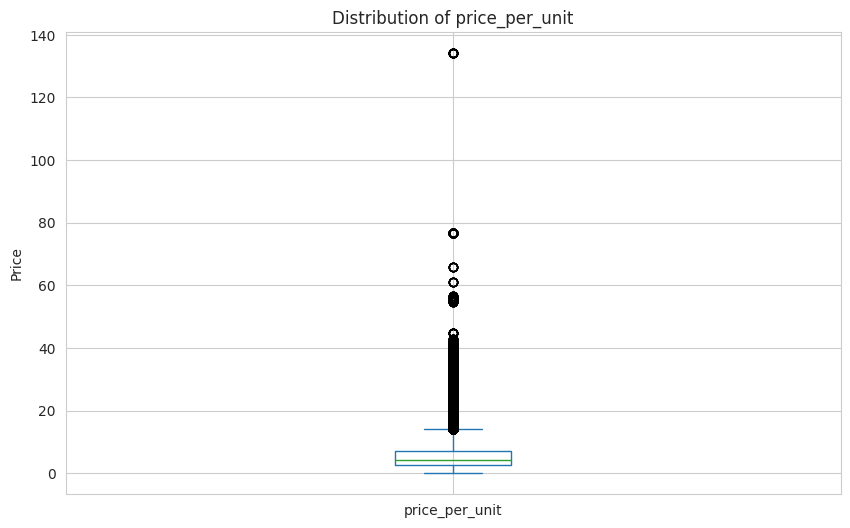

In [ ]:
df2['price_per_unit'].plot(kind='box', figsize=(10, 6))
plt.title('Distribution of price_per_unit')
plt.ylabel('Price')
plt.show()

In [ ]:
df2[df2['price_per_unit'] > 100]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
28732187,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-18,2013,2,5,201319,Saturday,6,18,841,0.0,134.15,0.00,No_event,4,0,False
28732188,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-19,2013,2,5,201319,Sunday,7,19,842,0.0,134.15,0.00,No_event,4,0,False
28732189,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-20,2013,2,5,201320,Monday,1,20,843,0.0,134.15,0.00,No_event,4,0,False
28732190,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-21,2013,2,5,201320,Tuesday,2,21,844,0.0,134.15,0.00,No_event,4,0,False
28732191,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-22,2013,2,5,201320,Wednesday,3,22,845,0.0,134.15,0.00,No_event,4,0,False
28732192,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-23,2013,2,5,201320,Thursday,4,23,846,0.0,134.15,0.00,No_event,4,0,False
28732193,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-24,2013,2,5,201320,Friday,5,24,847,1.0,134.15,134.15,No_event,4,0,False
28732194,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-25,2013,2,5,201320,Saturday,6,25,848,0.0,134.15,0.00,No_event,4,0,False
28732195,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-26,2013,2,5,201320,Sunday,7,26,849,0.0,134.15,0.00,No_event,4,0,False
28732196,HOME_&_GARDEN_2_406_PHI_3,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,Queen_Village,PHI_3,Philadelphia,2013-05-27,2013,2,5,201321,Monday,1,27,850,0.0,134.15,0.00,No_event,4,0,False


In [ ]:
df2[df2['id']=='HOME_&_GARDEN_2_406_PHI_3']['price_per_unit'].mode()

,price_per_unit
0,15.575


In [ ]:
df2[df2['id'] == 'HOME_&_GARDEN_2_406_PHI_3'].groupby('year')['price_per_unit'].max()

,price_per_unit
year,
2011,16.421078
2012,15.587500
2013,134.150000
2014,15.575000
2015,15.575000
2016,15.575000


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_2_406_PHI_3') & (df2['year'] == 2013)].groupby('month')['price_per_unit'].max()

,price_per_unit
month,
1,15.575
2,15.575
3,15.575
4,15.575
5,134.150
6,134.150
7,15.575
8,15.575
9,15.575


En definitiva, ese 134 debe ser un error. Reemplazamos por la mode

In [ ]:
mode_price = df2[df2['id'] == 'HOME_&_GARDEN_2_406_PHI_3']['price_per_unit'].mode()[0]

df2.loc[df2['price_per_unit'] > 100, 'price_per_unit'] = mode_price

In [ ]:
df2[df2['price_per_unit'] > 100]

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag


In [ ]:
df2[(df2['price_per_unit'] > 60) & (df2['price_per_unit'] < 100)]['id'].unique()


array(['HOME_&_GARDEN_2_406_PHI_2', 'HOME_&_GARDEN_2_466_BOS_1'],
      dtype=object)

#### HOME_&_GARDEN_2_406_PHI_2

In [ ]:
df2[df2['id'] == 'HOME_&_GARDEN_2_406_PHI_2'].groupby('year')['price_per_unit'].mean()

,price_per_unit
year,
2011,15.908680
2012,34.743682
2013,16.246233
2014,15.575000
2015,15.960479
2016,15.575000


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_2_406_PHI_2') & (df2['year'] == 2012)].groupby('month')['price_per_unit'].max()

,price_per_unit
month,
1,15.5875
2,15.5875
3,54.9875
4,30.8750
5,30.8750
6,30.8750
7,15.5875
8,15.5875
9,15.5875


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_2_406_PHI_2') & (df2['year'] == 2013)].groupby('month')['price_per_unit'].max()

,price_per_unit
month,
1,76.825
2,15.575
3,15.575
4,15.575
5,15.575
6,15.575
7,15.575
8,15.575
9,15.575


#### HOME_&_GARDEN_2_466_BOS_1

In [ ]:
df2[df2['id'] == 'HOME_&_GARDEN_2_466_BOS_1'].groupby('year')['price_per_unit'].max()

,price_per_unit
year,
2011,21.025
2012,65.775
2013,56.100
2014,60.975
2015,56.650
2016,42.150


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_2_466_BOS_1') & (df2['year'] == 2012)].groupby('month')['price_per_unit'].max()

,price_per_unit
month,
1,8.7125
2,8.7125
3,8.7125
4,8.7125
5,8.7125
6,54.8000
7,8.7125
8,56.0500
9,65.7750


In [ ]:
df2[(df2['id'] == 'HOME_&_GARDEN_2_466_BOS_1') & (df2['year'] == 2013)].groupby('month')['price_per_unit'].max()

,price_per_unit
month,
1,56.0500
2,8.7125
3,8.7125
4,8.7125
5,8.7125
6,56.1000
7,8.7125
8,27.4875
9,27.4875


### Actualizamos Revenue

In [ ]:
df2['revenue'] = df2['units_sold'] * df2['price_per_unit']

# Reset index

In [ ]:
df2.reset_index(drop=True, inplace=True)

In [ ]:
df2

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-29,2011,1,1,201104,Saturday,6,29,1,0.0,10.968041,0.0,No_event,4,0,False
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,2011,1,1,201104,Sunday,7,30,2,0.0,10.968041,0.0,No_event,4,0,False
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-31,2011,1,1,201105,Monday,1,31,3,0.0,10.968041,0.0,No_event,4,0,True
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,2011,1,2,201105,Tuesday,2,1,4,0.0,10.968041,0.0,No_event,4,0,True
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-02,2011,1,2,201105,Wednesday,3,2,5,0.0,10.968041,0.0,No_event,4,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58258497,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-20,2016,2,4,201616,Wednesday,3,20,1909,0.0,1.200000,0.0,No_event,3,0,False
58258498,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-21,2016,2,4,201616,Thursday,4,21,1910,0.0,1.200000,0.0,No_event,3,0,False
58258499,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-22,2016,2,4,201616,Friday,5,22,1911,0.0,1.200000,0.0,No_event,3,0,False
58258500,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-23,2016,2,4,201616,Saturday,6,23,1912,0.0,1.200000,0.0,No_event,3,0,False


# Understanding what we need to predict



 > *We usually start predicting sales at a store-product level, and to obtain aggregated sales per department/store/city we add up the independent predictions. Would that be still a valid approach? Let’s start with 28 days predictions (4 weeks).*

Como queremos predecir de forma semanal, creo que la ventas diarias presentan demasiado ruido. Intentare hacer la prediccion weekly, usando solo datos yearweek.

Niveles de predicciones:
- Product (per store)
- Department (per store)
- Store (per city)

In [ ]:
df2[df2['year'] == 2016]['month'].max()

4

In [ ]:
df2['yearweek'].max()

201616

In [ ]:
df2.query('yearweek == 201616')['weekday'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [ ]:
df2.query('yearweek == 201616')['date'].unique()

<DatetimeArray>
['2016-04-18 00:00:00', '2016-04-19 00:00:00', '2016-04-20 00:00:00',
 '2016-04-21 00:00:00', '2016-04-22 00:00:00', '2016-04-23 00:00:00',
 '2016-04-24 00:00:00']
Length: 7, dtype: datetime64[ns]

In [ ]:
# Extraemos la ultima yearweek
last_yearweek = df2['yearweek'].max()

last_year = last_yearweek // 100
last_week = last_yearweek % 100

# Generamos las siguientes semanas
yearweeks_to_predict = []
for i in range(1, 5):  # Comienza desde 1 para empezar justo después de la última semana
    next_week = last_week + i
    if next_week > 52:
        next_week -= 52
        next_year = last_year + 1
    else:
        next_year = last_year
    yearweeks_to_predict.append(next_year * 100 + next_week)

print("Yearweeks to predict:", yearweeks_to_predict)

Yearweeks to predict: [201617, 201618, 201619, 201620]


In [ ]:
def get_dates_for_yearweek(yearweek):
    year = yearweek // 100
    week = yearweek % 100
    # Crear un objeto datetime para el primer día del año
    start_of_year = pd.to_datetime(f'{year}-01-01')
    # Encontrar el primer sábado del año (semana 1)
    first_saturday = start_of_year + pd.DateOffset(days=(5 - start_of_year.weekday() + 7) % 7)
    # Calcular la fecha de inicio de la semana deseada
    week_start = first_saturday + Week(week - 1)
    # Generar la lista de fechas para esa semana (de sábado a viernes)
    return pd.date_range(start=week_start, periods=7)

# Define year, month, and yearweeks to predict
year = 2016
month_number = 5
month_name = pd.to_datetime(f'{year}-{month_number:02d}-01').strftime('%B')
yearweeks_to_predict = [201617, 201618, 201619, 201620]

# Crear un diccionario para almacenar las yearweeks y sus fechas correspondientes
yearweek_dates = {yearweek: get_dates_for_yearweek(yearweek) for yearweek in yearweeks_to_predict}

# Mostrar las yearweeks y sus fechas correspondientes
print(f"""Tenemos que predecir el Mes {month_number} ({month_name}) del {year}.
      Las semanas a predecir son:\n""")
for yearweek, dates in yearweek_dates.items():
    print(f"Yearweek {yearweek}: ")
    for date in dates:
        print(f"{date.strftime('%A')} '{date.date()}',")
    print("\n")

Tenemos que predecir el Mes 5 (May) del 2016.
      Las semanas a predecir son:

Yearweek 201617: 
Saturday '2016-04-23',
Sunday '2016-04-24',
Monday '2016-04-25',
Tuesday '2016-04-26',
Wednesday '2016-04-27',
Thursday '2016-04-28',
Friday '2016-04-29',


Yearweek 201618: 
Saturday '2016-04-30',
Sunday '2016-05-01',
Monday '2016-05-02',
Tuesday '2016-05-03',
Wednesday '2016-05-04',
Thursday '2016-05-05',
Friday '2016-05-06',


Yearweek 201619: 
Saturday '2016-05-07',
Sunday '2016-05-08',
Monday '2016-05-09',
Tuesday '2016-05-10',
Wednesday '2016-05-11',
Thursday '2016-05-12',
Friday '2016-05-13',


Yearweek 201620: 
Saturday '2016-05-14',
Sunday '2016-05-15',
Monday '2016-05-16',
Tuesday '2016-05-17',
Wednesday '2016-05-18',
Thursday '2016-05-19',
Friday '2016-05-20',




# Best_week_of_month feature

In [ ]:
df2

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-29,2011,1,1,201104,Saturday,6,29,1,0.0,10.968041,0.0,No_event,4,0,False
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,2011,1,1,201104,Sunday,7,30,2,0.0,10.968041,0.0,No_event,4,0,False
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-31,2011,1,1,201105,Monday,1,31,3,0.0,10.968041,0.0,No_event,4,0,True
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,2011,1,2,201105,Tuesday,2,1,4,0.0,10.968041,0.0,No_event,4,0,True
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-02,2011,1,2,201105,Wednesday,3,2,5,0.0,10.968041,0.0,No_event,4,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58258497,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-20,2016,2,4,201616,Wednesday,3,20,1909,0.0,1.200000,0.0,No_event,3,0,False
58258498,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-21,2016,2,4,201616,Thursday,4,21,1910,0.0,1.200000,0.0,No_event,3,0,False
58258499,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-22,2016,2,4,201616,Friday,5,22,1911,0.0,1.200000,0.0,No_event,3,0,False
58258500,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-23,2016,2,4,201616,Saturday,6,23,1912,0.0,1.200000,0.0,No_event,3,0,False


In [ ]:
# Function to calculate week of the month
def week_of_month(date):
    # Get the first day of the month
    first_day = date.replace(day=1)
    # Calculate the week number of the first day of the month
    first_day_week = first_day.weekday()  # 0 = Monday, 6 = Sunday
    # Calculate the day of the month as an offset from the first day of the week
    dom = date.day
    # Calculate the week of the month
    adjusted_dom = dom + first_day_week
    return int(np.ceil(adjusted_dom / 7.0))

# Apply the function to create the 'week_of_month' feature
df2['week_of_month'] = df2['date'].apply(week_of_month)

# Verify the new feature
df2[['date', 'week_of_month']].head(30)  # Display the first 30 entries to check the weeks

,date,week_of_month
0,2011-01-29,5
1,2011-01-30,5
2,2011-01-31,6
3,2011-02-01,1
4,2011-02-02,1
5,2011-02-03,1
6,2011-02-04,1
7,2011-02-05,1
8,2011-02-06,1
9,2011-02-07,2


In [ ]:
SUPERMARKET_3_827_PHI_3_last = df2[(df2['id'] == 'SUPERMARKET_3_827_PHI_3') & (df2['month'] == 4) & (df2['year'] == 2016)]

In [ ]:
SUPERMARKET_3_827_PHI_3_last[['date','year', 'month','yearweek', 'weekday', 'week_of_month']]

,date,year,month,yearweek,weekday,week_of_month
58258478,2016-04-01,2016,4,201613,Friday,1
58258479,2016-04-02,2016,4,201613,Saturday,1
58258480,2016-04-03,2016,4,201613,Sunday,1
58258481,2016-04-04,2016,4,201614,Monday,2
58258482,2016-04-05,2016,4,201614,Tuesday,2
58258483,2016-04-06,2016,4,201614,Wednesday,2
58258484,2016-04-07,2016,4,201614,Thursday,2
58258485,2016-04-08,2016,4,201614,Friday,2
58258486,2016-04-09,2016,4,201614,Saturday,2
58258487,2016-04-10,2016,4,201614,Sunday,2


In [ ]:
df2.columns

Index(['id', 'item', 'category', 'department', 'store', 'store_code', 'region',
       'date', 'year', 'quarter', 'month', 'yearweek', 'weekday',
       'weekday_int', 'day', 'd', 'units_sold', 'price_per_unit', 'revenue',
       'event', 'product_cluster', 'store_cluster', 'Event_week_flag',
       'week_of_month'],
      dtype='object')

In [ ]:
# Step 1: Calculate total units sold for each week_of_month
weekly_sales = df2.groupby(['id', 'year', 'month', 'week_of_month'])['units_sold'].sum().reset_index()

# Step 2: Identify the week_of_month with the most sales for each id, year, and month
max_sales_per_month = weekly_sales.groupby(['id', 'year', 'month'])['units_sold'].transform('max')

# Create a flag for the best week_of_month
weekly_sales['best_week_of_the_month'] = weekly_sales['units_sold'] == max_sales_per_month

# Ensure that months with no sales are flagged as False
weekly_sales['best_week_of_the_month'] = np.where(weekly_sales['units_sold'] > 0, weekly_sales['best_week_of_the_month'], False)

# Step 3: Merge this back into the original df2
df2 = df2.merge(weekly_sales[['id', 'year', 'month', 'week_of_month', 'best_week_of_the_month']],
                on=['id', 'year', 'month', 'week_of_month'], how='left')

# Verify the new feature
df2[['id', 'year', 'month', 'week_of_month', 'units_sold', 'best_week_of_the_month']].head(30)

,id,year,month,week_of_month,units_sold,best_week_of_the_month
0,ACCESORIES_1_001_BOS_1,2011,1,5,0.0,False
1,ACCESORIES_1_001_BOS_1,2011,1,5,0.0,False
2,ACCESORIES_1_001_BOS_1,2011,1,6,0.0,False
3,ACCESORIES_1_001_BOS_1,2011,2,1,0.0,False
4,ACCESORIES_1_001_BOS_1,2011,2,1,0.0,False
5,ACCESORIES_1_001_BOS_1,2011,2,1,0.0,False
6,ACCESORIES_1_001_BOS_1,2011,2,1,0.0,False
7,ACCESORIES_1_001_BOS_1,2011,2,1,0.0,False
8,ACCESORIES_1_001_BOS_1,2011,2,1,0.0,False
9,ACCESORIES_1_001_BOS_1,2011,2,2,0.0,False


In [ ]:
# Verify the new feature
df2[['id', 'year', 'month', 'yearweek', 'week_of_month', 'units_sold', 'best_week_of_the_month']]

,id,year,month,yearweek,week_of_month,units_sold,best_week_of_the_month
0,ACCESORIES_1_001_BOS_1,2011,1,201104,5,0.0,False
1,ACCESORIES_1_001_BOS_1,2011,1,201104,5,0.0,False
2,ACCESORIES_1_001_BOS_1,2011,1,201105,6,0.0,False
3,ACCESORIES_1_001_BOS_1,2011,2,201105,1,0.0,False
4,ACCESORIES_1_001_BOS_1,2011,2,201105,1,0.0,False
...,...,...,...,...,...,...,...
58258497,SUPERMARKET_3_827_PHI_3,2016,4,201616,4,0.0,False
58258498,SUPERMARKET_3_827_PHI_3,2016,4,201616,4,0.0,False
58258499,SUPERMARKET_3_827_PHI_3,2016,4,201616,4,0.0,False
58258500,SUPERMARKET_3_827_PHI_3,2016,4,201616,4,0.0,False


# Best_month_of_quarter feature

In [ ]:
# Step 1: Calculate total units sold for each month within each quarter
monthly_sales = df2.groupby(['id', 'year', 'quarter', 'month'])['units_sold'].sum().reset_index()

# Step 2: Identify the month with the most sales within each quarter for each id
max_sales_per_quarter = monthly_sales.groupby(['id', 'year', 'quarter'])['units_sold'].transform('max')

# Create a flag for the best month of the quarter
monthly_sales['best_month_of_quarter'] = monthly_sales['units_sold'] == max_sales_per_quarter

# Ensure that quarters with no sales are flagged as False
monthly_sales['best_month_of_quarter'] = np.where(monthly_sales['units_sold'] > 0, monthly_sales['best_month_of_quarter'], False)

# Step 3: Merge this back into the original df2
df2 = df2.merge(monthly_sales[['id', 'year', 'quarter', 'month', 'best_month_of_quarter']],
                on=['id', 'year', 'quarter', 'month'], how='left')

# Verify the new feature
df2[['id', 'year', 'quarter', 'month', 'units_sold', 'best_month_of_quarter']].tail(30)

,id,year,quarter,month,units_sold,best_month_of_quarter
58258472,SUPERMARKET_3_827_PHI_3,2016,1,3,0.0,True
58258473,SUPERMARKET_3_827_PHI_3,2016,1,3,5.0,True
58258474,SUPERMARKET_3_827_PHI_3,2016,1,3,7.0,True
58258475,SUPERMARKET_3_827_PHI_3,2016,1,3,3.0,True
58258476,SUPERMARKET_3_827_PHI_3,2016,1,3,1.0,True
58258477,SUPERMARKET_3_827_PHI_3,2016,1,3,4.0,True
58258478,SUPERMARKET_3_827_PHI_3,2016,2,4,3.0,True
58258479,SUPERMARKET_3_827_PHI_3,2016,2,4,3.0,True
58258480,SUPERMARKET_3_827_PHI_3,2016,2,4,1.0,True
58258481,SUPERMARKET_3_827_PHI_3,2016,2,4,2.0,True


In [ ]:
df2

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag,week_of_month,best_week_of_the_month,best_month_of_quarter
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-29,2011,1,1,201104,Saturday,6,29,1,0.0,10.968041,0.0,No_event,4,0,False,5,False,False
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,2011,1,1,201104,Sunday,7,30,2,0.0,10.968041,0.0,No_event,4,0,False,5,False,False
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-31,2011,1,1,201105,Monday,1,31,3,0.0,10.968041,0.0,No_event,4,0,True,6,False,False
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,2011,1,2,201105,Tuesday,2,1,4,0.0,10.968041,0.0,No_event,4,0,True,1,False,False
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-02,2011,1,2,201105,Wednesday,3,2,5,0.0,10.968041,0.0,No_event,4,0,True,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58289105,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-20,2016,2,4,201616,Wednesday,3,20,1909,0.0,1.200000,0.0,No_event,3,0,False,4,False,True
58289106,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-21,2016,2,4,201616,Thursday,4,21,1910,0.0,1.200000,0.0,No_event,3,0,False,4,False,True
58289107,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-22,2016,2,4,201616,Friday,5,22,1911,0.0,1.200000,0.0,No_event,3,0,False,4,False,True
58289108,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-23,2016,2,4,201616,Saturday,6,23,1912,0.0,1.200000,0.0,No_event,3,0,False,4,False,True


# Best_quarter_of_year

In [ ]:
# Step 1: Calculate total units sold for each quarter within each year
quarterly_sales = df2.groupby(['id', 'year', 'quarter'])['units_sold'].sum().reset_index()

# Step 2: Identify the maximum sales per year for each ID
max_sales_per_year = quarterly_sales.groupby(['id', 'year'])['units_sold'].max().reset_index()
max_sales_per_year.rename(columns={'units_sold': 'max_units_sold'}, inplace=True)

# Step 3: Merge the max_sales_per_year back with the quarterly_sales
quarterly_sales = quarterly_sales.merge(max_sales_per_year, on=['id', 'year'])

# Step 4: Mark the quarter with the maximum sales as the best quarter
quarterly_sales['best_quarter_of_year'] = (quarterly_sales['units_sold'] == quarterly_sales['max_units_sold'])

# Step 5: In case of ties (multiple quarters with the same max sales), ensure only one quarter is marked as best
quarterly_sales = quarterly_sales.sort_values(by=['id', 'year', 'units_sold'], ascending=[True, True, False])
quarterly_sales['rank'] = quarterly_sales.groupby(['id', 'year'])['units_sold'].rank(method='first', ascending=False)
quarterly_sales['best_quarter_of_year'] = quarterly_sales['rank'] == 1

# Step 6: Drop the auxiliary columns used for ranking
quarterly_sales.drop(columns=['max_units_sold', 'rank'], inplace=True)

# Step 7: Merge this back into the original df2
df2 = df2.merge(quarterly_sales[['id', 'year', 'quarter', 'best_quarter_of_year']],
                on=['id', 'year', 'quarter'], how='left')

# Verify the new feature
df2[['id', 'year', 'quarter', 'units_sold', 'best_quarter_of_year']].tail(30)

,id,year,quarter,units_sold,best_quarter_of_year
58258472,SUPERMARKET_3_827_PHI_3,2016,1,0.0,True
58258473,SUPERMARKET_3_827_PHI_3,2016,1,5.0,True
58258474,SUPERMARKET_3_827_PHI_3,2016,1,7.0,True
58258475,SUPERMARKET_3_827_PHI_3,2016,1,3.0,True
58258476,SUPERMARKET_3_827_PHI_3,2016,1,1.0,True
58258477,SUPERMARKET_3_827_PHI_3,2016,1,4.0,True
58258478,SUPERMARKET_3_827_PHI_3,2016,2,3.0,False
58258479,SUPERMARKET_3_827_PHI_3,2016,2,3.0,False
58258480,SUPERMARKET_3_827_PHI_3,2016,2,1.0,False
58258481,SUPERMARKET_3_827_PHI_3,2016,2,2.0,False


In [ ]:
df2

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag,week_of_month,best_week_of_the_month,best_month_of_quarter,best_quarter_of_year
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-29,2011,1,1,201104,Saturday,6,29,1,0.0,10.968041,0.0,No_event,4,0,False,5,False,False,True
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,2011,1,1,201104,Sunday,7,30,2,0.0,10.968041,0.0,No_event,4,0,False,5,False,False,True
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-31,2011,1,1,201105,Monday,1,31,3,0.0,10.968041,0.0,No_event,4,0,True,6,False,False,True
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,2011,1,2,201105,Tuesday,2,1,4,0.0,10.968041,0.0,No_event,4,0,True,1,False,False,True
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-02,2011,1,2,201105,Wednesday,3,2,5,0.0,10.968041,0.0,No_event,4,0,True,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58258497,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-20,2016,2,4,201616,Wednesday,3,20,1909,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False
58258498,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-21,2016,2,4,201616,Thursday,4,21,1910,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False
58258499,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-22,2016,2,4,201616,Friday,5,22,1911,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False
58258500,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-23,2016,2,4,201616,Saturday,6,23,1912,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False


#PICKLE DF2


In [ ]:
df2.to_pickle('/content/drive/MyDrive/Data Science Class/TFM/df_DSMARKET_FORECASTING')

# PICKLE CALL DF2

In [ ]:
df2 = pd.read_pickle('/content/drive/MyDrive/Data Science Class/TFM/df_DSMARKET_FORECASTING')

In [ ]:
df2

,id,item,category,department,store,store_code,region,date,year,quarter,month,yearweek,weekday,weekday_int,day,d,units_sold,price_per_unit,revenue,event,product_cluster,store_cluster,Event_week_flag,week_of_month,best_week_of_the_month,best_month_of_quarter,best_quarter_of_year
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-29,2011,1,1,201104,Saturday,6,29,1,0.0,10.968041,0.0,No_event,4,0,False,5,False,False,True
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,2011,1,1,201104,Sunday,7,30,2,0.0,10.968041,0.0,No_event,4,0,False,5,False,False,True
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-31,2011,1,1,201105,Monday,1,31,3,0.0,10.968041,0.0,No_event,4,0,True,6,False,False,True
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,2011,1,2,201105,Tuesday,2,1,4,0.0,10.968041,0.0,No_event,4,0,True,1,False,False,True
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-02,2011,1,2,201105,Wednesday,3,2,5,0.0,10.968041,0.0,No_event,4,0,True,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58258497,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-20,2016,2,4,201616,Wednesday,3,20,1909,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False
58258498,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-21,2016,2,4,201616,Thursday,4,21,1910,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False
58258499,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-22,2016,2,4,201616,Friday,5,22,1911,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False
58258500,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-23,2016,2,4,201616,Saturday,6,23,1912,0.0,1.200000,0.0,No_event,3,0,False,4,False,True,False


In [ ]:
df2['best_quarter_of_year'].value_counts()

,count
best_quarter_of_year,
False,42124686
True,16133816


In [ ]:
df2[(df2['best_quarter_of_year'] == True) & (df2['year'] == 2015) & (df2['id'] == 'SUPERMARKET_3_827_PHI_3')]['quarter'].unique()

array([2], dtype=int32)

In [ ]:
# df2['week_of_month'].value_counts()

,count
week_of_month,
3,13430214
2,13430214
4,13430214
5,9775734
1,7613500
6,578626


In [ ]:
# weeks_per_month = df2.groupby(['year', 'month'])['week_of_month'].nunique()
# months_with_6_weeks = weeks_per_month[weeks_per_month == 6]
# months_with_6_weeks

year  month
2011  5        6
      10       6
2012  1        6
      4        6
      7        6
      12       6
2013  9        6
      12       6
2014  3        6
      6        6
2015  3        6
      8        6
      11       6
Name: week_of_month, dtype: int64